# Data analysis recipes: Fitting a model to data
## A workbook following the exercises in [Hogg, Bovy, and Lang (2010)](https://arxiv.org/pdf/1008.4686)

In [1]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Latex, Math, Markdown
from matplotlib.colors import LogNorm

import emcee
from tqdm import tqdm
from multiprocessing import Pool
%matplotlib inline

#### Many of the exercises laid out in [the paper](https://arxiv.org/pdf/1008.4686) refer back to Table 1 (p. 6) which I include below for convenience:

<img src="Table1_hbl.png" width="220" height="220" align="center"/>

### 1. <u>Standard Practice: the Least Squares Approach</u>

The first section of the paper dives straight into employing the "standard practice", i.e. least squares fitting, to obtain a polynomial function which fits a set of data. It is the most simple and straight-forward fitting method which assumes the following about the data: there are more than 2 data points (x,y), with known Gaussian uncertainties in the y direction, and negligible uncertainties in the x direction.  The simple statistical procedure allows for the 'best-fit' model parameters, in this case $(m,b)$ in $y = mx + b$, to be obtained through matrix manipulation.

The paper describes how to construct the matrices $\textbf{Y}$ (Eq. 2), $\textbf{A}$ (Eq. 3), and $\textbf{C}$ (Eq. 4) where $\boldsymbol{Y}$ contains the $\textit{y}$ data, $\boldsymbol{A}$ contains the $\textit{x}$ data and is structured to reflect the order of the polynomial, and $\boldsymbol{C}$ is the covariance matrix.  These matrices can be generalized to higher order polynomials by simply adding columns for each order to matrix $\boldsymbol{A}$ where the value of $\textit{x}$ is brought to the power of said order.  The authors then present Eq. 5, which shows how to manipulate the previously constructed matrices to obtain the 'best-fit' values for $m$ and $b$.  Following this, they explain how Eq. 5 is justified as it minimizes an objective function $\chi^2$ (Eq. 7) which represents the quality of the fit.

#### $\textbf{Exercise 1 (p. 5):}$ Fit y = mx + b to data points 5 - 20 from Table 1, ignore $\sigma_{x}$ and $\rho_{xy}$.  Make a plot showing the points, uncertainties, and best-fit line (Compare to Figure 1).  What is the standard uncertainty variance on the slope of the line?

In [2]:
#create arrays with the necessary data from Table 1, for now we will omit the first 4 points (aka use everything after the 4th point in the table) 
x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

#build the matrices as described in the first section (p. 4, eq. 2-4)
Y = np.reshape(y[4:], (len(y[4:]),1))

#build A matrix
ones = np.ones_like(x[4:])
A = np.column_stack((ones, x[4:]))

#build covariance matrix C
C = np.diag(sigma_y[4:]**2)

#now multiply following the format of Eq. 5 to create the vector X
#transpose of A
A_T = A.T

#inverse of C
C_inv = np.linalg.inv(C)


ATCINV = np.matmul(A_T, C_inv)


ACA = np.matmul(ATCINV, A)

#when the uncertainties are Gaussian, this is the covariance matrix of X, where the diagonals are the variance values
#and the off-diagonals are the covariance 
ACA_inv = np.linalg.inv(ACA)

ACY = np.matmul(ATCINV, Y)


#column vector that has best fit parameters for b and m
X = np.matmul(ACA_inv, ACY)

Now plot!

In [3]:
#setting plotting preferences in matplotlib

#use LateX to make the plots look a bit nicer
plt.rc('text',usetex=True)
plt.rc('font', family='serif')

#colors
blue = '#377eb8'
purple = '#984ea3'

#markersize (ms), capsize, transparency (alpha)
ms = 10
capsize = 5           
alpha = 0.8

#axis label fontsize
label_size = 15

#title fontsize
title_size = 18

#tick labels fontsize
tick_label_size = 12


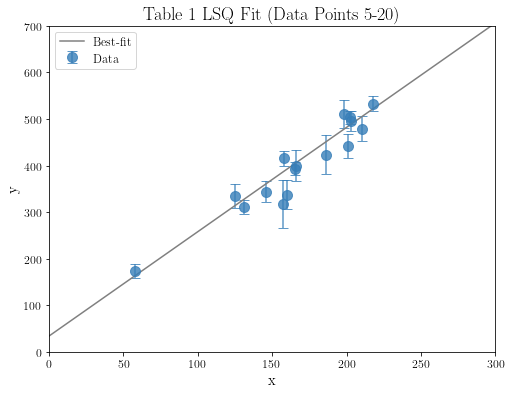

In [4]:
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 LSQ Fit (Data Points 5-20)', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x[4:], y[4:], fmt = 'o', yerr=sigma_y[4:], markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, X[1,0] * x_line + X[0,0], color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')


fig.savefig('/insert/path/here/lsq_data_5_20.png', bbox_inches = 'tight')

In [5]:
# the y-intercept (b) is given by the first element of the X vector
# it's uncertainty is given by the square root of the first element [0,0] of the matrix [A^T C^-1 A]^-1 as stated on p. 5
y_int = X[0,0]
y_uncert = np.sqrt(ACA_inv[0,0])

#the slope (m) is given by the second element of X
# and it's uncertainty is given by the square root of the fourth element [1,1] in the matrix mentioned above
m = X[1,0]
m_uncert = np.sqrt(ACA_inv[1,1])

#the slope's variance is simply the [1,1] element 
m_var = ACA_inv[1,1]

display(Markdown(r'Best fit line: $y = ({} \pm {})x + ({} \pm {})$'.format(np.round(m,2), np.round(m_uncert,2), np.round(y_int, 2), np.round(y_uncert,2))))

display(Markdown(r'$\sigma_m^2$: {}'.format(np.round(m_var,5))))

Best fit line: $y = (2.24 \pm 0.11)x + (34.05 \pm 18.25)$

$\sigma_m^2$: 0.01162

#### $\textbf{Exercise 2 (p.5):}$ Repeat Exercise 1 but with all the points from Table 1 (Compare plot to Figure 2), what is the uncertainty variance on the slope of the line?  Is there anything you don’t like about the result?  Is there anything different about the new points you have included beyond those used in Exercise 1?

In [33]:
#now do the same thing again, but using all of the data points given in Table 1

#the matrix construction and manipulations from above (minus comments)
Y = np.reshape(y, (len(y),1))

ones = np.ones_like(x)
A = np.column_stack((ones, x))

C = np.diag(sigma_y**2)

A_T = A.T

C_inv = np.linalg.inv(C)

ATCINV = np.matmul(A_T, C_inv)

ACA = np.matmul(ATCINV, A)

ACA_inv = np.linalg.inv(ACA)

ACY = np.matmul(ATCINV, Y)

#column vector that has best fit parameters for b and m
X = np.matmul(ACA_inv, ACY)

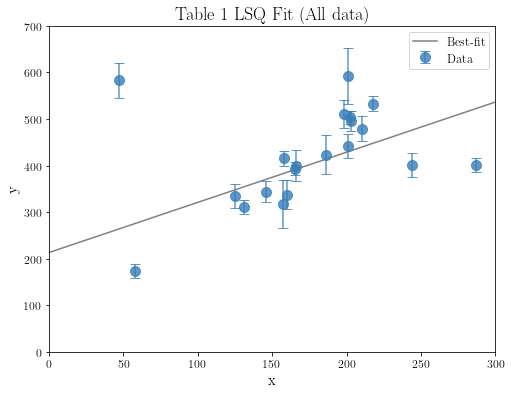

In [7]:
#now plot!
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 LSQ Fit (All data)', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x, y, fmt = 'o', yerr=sigma_y, markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, X[1,0] * x_line + X[0,0], color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')


fig.savefig('/insert/path/here/lsq_all_data.png', bbox_inches = 'tight')

In [8]:
#display the results and compare with Figure 2 in HBL (2010) 
# the y-intercept (b) is given by the first element of the X vector
y_int = X[0,0]
y_uncert = np.sqrt(ACA_inv[0,0])

m = X[1,0]
m_uncert = np.sqrt(ACA_inv[1,1])

m_var = ACA_inv[1,1]

display(Markdown(r'Best fit line: $y = ({} \pm {})x + ({} \pm {})$'.format(np.round(m,2), np.round(m_uncert,2), np.round(y_int, 2), np.round(y_uncert,2))))

display(Markdown(r'$\sigma_m^2$: {}'.format(np.round(m_var,5))))

Best fit line: $y = (1.08 \pm 0.08)x + (213.27 \pm 14.39)$

$\sigma_m^2$: 0.00599

The variance in the slope is smaller than it was before, and the slope itself does not seem to fit the data as well as it did.  This implies that the first four points of the data set do not seem to follow the same line as cleanly as the rest of the data.      

#### $\textbf{Exercise 3 (p.5):}$ Generalize the method of this section to fit a general quadratic relationship.  Add another column to matrix $\textbf{A}$ containing the values $x_{i}^2$ and another element to vector $\textbf{X}$ (call it $q$).  Re-do Exercise 1 but fitting for and plotting the best quadratic relationship $g(x) = qx^{2} + mx + b$ (Compare plot to Figure 3).

In [9]:
#recreate arrays of data points 5-20 which we will sort by x to make plot look nicer
x = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

#sort by x value
sorter = np.argsort(x)

x = x[sorter]
y = y[sorter]
sigma_y = sigma_y[sorter]

#build matrices like we did above
Y = np.reshape(y, (len(y),1))

#covariance matrix C
C = np.diag(sigma_y**2)

#A matrix with a column for the squared x values
x_sq = x**2
ones = np.ones_like(x)
A = np.column_stack((ones, x, x_sq))

#covariance matrix C
C = np.diag(sigma_y**2)

#transpose of A
A_T = A.T

#inverse of C
C_inv = np.linalg.inv(C)


ATCINV = np.matmul(A_T, C_inv)
ACA = np.matmul(ATCINV, A)
ACA_inv = np.linalg.inv(ACA)
ACY = np.matmul(ATCINV, Y)


#column vector that has best fit parameters for b, m, q
X = np.matmul(ACA_inv, ACY)

#quadratic function
g = X[2,0]*x_sq + X[1,0]*x + X[0,0]

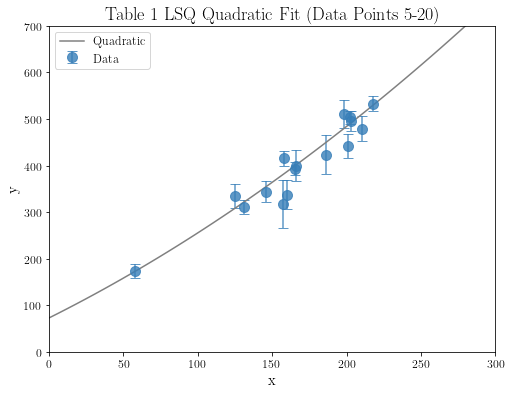

In [10]:
#now plot!
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 LSQ Quadratic Fit (Data Points 5-20)', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)
g_line = X[2,0]*x_line**2 + X[1,0]*x_line + X[0,0]

#plot the data points
ax.errorbar(x, y, fmt = 'o', yerr=sigma_y, markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, g_line, color = 'gray', label='Quadratic')

#make the legend
ax.legend(fontsize='large')


fig.savefig('/insert/path/here/lsq_quad_5_20.png', bbox_inches = 'tight')

In [11]:
#display the results and compare with Figure 3 in HBL (2010) 
y_int = X[0,0]
y_uncert = np.sqrt(ACA_inv[0,0])

m = X[1,0]
m_uncert = np.sqrt(ACA_inv[1,1])

q = X[2,0]
q_uncert = np.sqrt(ACA_inv[2,2])

display(Markdown(r'$y = ({} \pm {})x^2 + ({} \pm {})x + ({} \pm {})$'.format(np.round(q,4), np.round(q_uncert,4), np.round(m,2), np.round(m_uncert,2), np.round(y_int, 2), np.round(y_uncert,2))))

$y = (0.0023 \pm 0.002)x^2 + (1.6 \pm 0.58)x + (72.89 \pm 38.91)$

### 2. <u>The objective function</u>

In this section, the authors break down the concept of finding and optimizing an objective function.  An objective function is a representation of the quality of the model's fit to the data and is based on one's knowledge of the problem.  Thus, optimizing this function will allow one to find the posterior probability distribution function (PDF) in which the parameters of the model with the highest probability of fitting the data lie. In order to obtain this objective function, you first need to make a generative model, i.e. a justifiable statistical procedure that could have generated your data set and would allow you to make probabilistic inferences.

For the case of fitting a straight line to a set of data, one can assume that the data set really does come from a line $y = mx + b$ and the only reason some points do not lie on it is because of some offset in the y-direction pulled from a Gaussian distribution with zero mean and known variance $\sigma^2_y$.  Therefore, the probability of getting a $y_{i}$ given an independent $x_{i}$, uncertainty $\sigma_{yi}$, and model parameters $\textit{m}$ and $\textit{b}$  would be Eq. 9.

Knowing this, we want to find the model that maximizes the probability of getting the observed data given the model and prior knowledge, i.e. the likelihood of the model parameters.  Since the data points are drawn independently, the likelihood $\mathscr{L}$ can be written as the product of conditional probabilities (Eq. 10).  Then taking the natural log for easier mathematical calculations you get Eq. 11, where $K$ is a constant, and $\chi^2$ is your objective function.  This shows how maximizing the likelihood directly correlates to minimizing $\chi^2$.

This premise can be generalized in a Bayesian manner, reflecting the form of Bayes' Theorem, as (Eq. 12): 

<h4><center> $\begin{equation} \label{post_prob_dist}
    p(m, b | {y_{i}}_{i=1}^{N}, I ) = \frac{p({y_{i}}_{i=1}^{N}|m, b, I)p(m,b|I)}{p({y_{i}}_{i=1}^{N}|I)}
\end{equation}$ </center></h4>

Where $ p(m, b | {y_{i}}_{i=1}^{N}, I )$ is the posterior probability distribution which is the probability of getting the model parameters $(\textit{m},\textit{b})$ given the data ${y_{i}}_{i=1}^{N}$ and prior knowledge $\textit{I}$.  This is obtained by multiplying the likelihood of the model parameters $p({y_{i}}_{i=1}^{N}|m, b, I)$ and the prior probability distribution $p(m,b|I)$, which is the probability of getting the correct model parameters given your knowledge of the situation before seeing any data, and normalized by marginalizing the numerator over every parameter.  Marginalization in this case refers to summing over the possible values of one parameter to determine the marginal contribution of another.  

#### *skipping Exercises 4 & 5 to focus more on the model fitting techniques in this notebook*

### 3. <u> Pruning outliers - with MCMC algorithms </u>

As shown in Ex. 2, the Least Square fitting (LSQ) technique is heavily susceptible to outliers.  Therefore, the method needs to be adapted to account for them.  One such way to do so is objectively determining the 'good' and 'bad' points and rejecting the bad ones.  For each point in a set of $\textit{N}$ data points, assign a binary integer $q_i$ where $q_i = 1$ if the $\rm i^{th}$ data point is good and $q_i = 0$ if it is bad.  Like before, the goal is to construct an objective function which also includes $P_b$, the prior probability that any individual data point is bad, and the mean and variance of the distribution of bad points ($Y_b, V_b$).  Accordingly, you need a generative model for the data that generates both the good and bad points.  The foreground (good) data $p_{fg}$ can be modeled similarly to before, a line with offsets in the y-direction drawn from a Gaussian distribution of zero mean and variance $\sigma^2_y$.  While the background (bad) data $p_{bg}$ can be modeled by a Gaussian distribution of y-data with mean $Y_b$ and variance $V_b$.  The likelihood would then look like Eq. 13.  Since data rejection is allowed, it is important to incorporate the prior binomial probability on the $\{q_i\}^N_{i=1}$ which penalises each rejection with the prior probability for the foreground and background models (Eq. 14). 

The full posterior probability distribution is then given by Eq. 15, where $\theta \equiv (m, b, \{q_i\}^N_{i=1}, P_b, Y_b, V_b)$, and like in Eq. 12, the denominator acts as a normalization integral that makes $p(\theta,I)$ integrate to 1. As a reminder, the goal is to obtain the posterior probability distribution for the model parameters $(m,b)$, which motivates the marginalization of the 'bad' data model parameters (Eq. 16).  This effectively integrates over all the possibilities for $\{q_i\}^N_{i=1}, P_b, Y_b,$ and $V_b$ permitted by their priors contained in $p(\theta|I)$.  In other words, this process involves evaluating $2^N$ likelihoods for each possibility of $q_i$ and summing over all of the possible values of $P_b, Y_b, \text{and } V_b$ for each likelihood.  Therefore, the final generative mixture model to be used is Eq. 17.

Since the likelihood now contains nuisance parameters ($P_b, Y_b, V_b$) that need to be marginalized, LSQ is no longer a suitable means for properly obtaining the maximum-likelihood model parameters ($m,b$).  However, it is also analytically expensive to numerically integrate the posterior probability distribution directly over every nuisance parameter.  Therefore, we turn to Markov Chain Monte Carlo (MCMC) schemes.  An MCMC is a sampling method that draws samples from the posterior distribution and allows for the estimation of its shape. It is especially convenient for distributions influenced by multiple parameters, and allows one to obtain the estimates of the parameters they care about with uncertainties that account for their covariances with the nuisance parameters.

It works by picking a random value of a parameter in parameter space and evaluating how likely it is for that value to explain the data, given the prior knowledge.  Then it will take a random step, again informed by the prior, in said parameter space and compute the new likelihood at the new value.  If the likelihood of the new parameter value is higher than that of the previous value, it is added to the chain of values with probabilities based on how much more likely they are to explain the data.  This process is iterated and after some time, the samples tend to converge to the region in parameter space with the highest probability.  Once this occurs, the MCMC returns samples of the posterior distribution computed with those 'highest-probability' parameter values.  And in the case of having multiple parameters, an MCMC can explore the probabilistic space and converge on sets of parameters that have higher probabilities of explaining the data.

To apply this, I use the emcee python package to perform the MCMC sampling on the posterior distribution defined by the combination of the prior and the mixture model (Eq. 17) to fit the data.  It takes a log probability function of the combined prior and likelihood as input, and performs the MCMC procedure with a user-defined amount of walkers, which explore the parameter space, for however many steps the user wants each one to take.  Upon completion, it returns the chain of samples from the posterior probability distribution with the number of dimensions corresponding to the number of parameters sampled.  For the model defined by Eq. 17 in which the background parameters are marginalized, emcee returns samples of the $\textit{fully marginalized}$ posterior for each parameter.  It is then possible to visualize the approximated posterior distribution for a parameter by creating a histogram of its samples.


#### $\textbf{Exercise 6 (p. 17):}$ Find the best-fit (the maximum $\textit{a posteriori}$) straight line $y=mx+b$ for the $x$,$y$, and $\sigma_y$ data in Table 1 using the mixture model approach outlined in this section.  

- Before choosing the MAP line, marginalize over parameters $(P_b,Y_b,V_b)$.  That is, if you take a sampling approach, this means sampling the full five-dimensional parameter space but then choosing the peak value in the histogram of samples in the two-dimensional parameter space $(m,b)$.  

- Make one plot showing this two-dimensional histogram, and another showing the points, their uncertainties, and the MAP line.  How does this compare to the standard result you obtained in Exercise 2?  Do you like the MAP line better or worse? Your plot should look like Figure 4.

In [12]:
#copy and paste the arrays from above for convenience
x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

#divide sigma_y by 2 (to be used in Ex. 7)
sigma_y2 = sigma_y/2.0

#number of parameter space explorers (walkers)
nwalkers = 100

#number of dimensions = number of parameters being explored (m, b, Pb, Yb, Vb)
ndim = 5

#number of steps each walker takes, to ensure parameter space is explored properly
nsteps = 5000

#number of steps discarded
nburn = int(nsteps/2)

In [13]:
#create a function that describes the log probability of priors
def lnprior(params):
#inputs: array of parameters being explored
    m = params[0]
    b = params[1]
    Yb = params[2]
    Vb = params[3]
    Pb = params[4]
    
    #we know the probability of a data point being bad cannot be less than 0 or more than one and the 
    #standard deviation of the gaussian describing the outliers cannot be less than 0, so if that is the case
    #return infinity (i.e. since likelihood of those events is 0 ln of likelihood should return -infinity)
    if Pb < 0 or Pb > 1 or Vb < 0.:
        return -np.inf
    else:
        return 0
        #if it is in the realm of possibility, return 0
        #it does not have to be 0, it just needs to be some constant
        

#function that describes the log likelihood of the given model parameters with the log probability of the priors (eq. 17)   
def lnlikelihood(params,*args,**kwargs):
    m = params[0]
    b = params[1]
    Yb = params[2]
    Vb = params[3]
    Pb = params[4]
    
    #return negative infinity of 
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf

    #likelihood equation (combination of 2 gaussians)
    #if completing exercise 7, rerun this cell but replate sigma_y with sigma_y2 array
    straightline = (1-Pb)*np.exp(-(y - m*x - b)**2./(2.*sigma_y**2.))/np.sqrt(2.*np.pi*sigma_y**2.)
    outliers = Pb*np.exp(-(y - Yb)**2./(2.*(Vb + sigma_y**2.)))/np.sqrt(2.*np.pi*(Vb + sigma_y**2.))
    lnlhood = np.sum(np.log(straightline + outliers))
    
    #return sum of prior and likelihood
    return lp+lnlhood

In [14]:
#use the log uniform distribution function built into scipy to create the prior for Vb
from scipy.stats import loguniform 


#generates initial conditions 
def gen_ICs():
    ret_array = np.zeros(ndim)
    ret_array[0] = np.random.uniform(0,10)      #we know the true values of m and b from exercise 1, but let's pretend we don't and make reasonable guesses
    ret_array[1] = np.random.uniform(0,100)
    ret_array[2] = np.random.uniform(300,600)  #assuming uninformative prior for Yb and Vb (as mentioned on page 12)
    ret_array[3] = loguniform.rvs(0.01, 4)  
    ret_array[4] = np.random.uniform(0,1)   #uniform distribution for Pb 
    return ret_array

#creates arrays of initial conditions for number of walkers specified
def gen_IC_array():
    return [gen_ICs() for i in range(nwalkers)]

ICs = gen_IC_array()

In [15]:
#show initial conditions array to make sure they look reasonable
gen_ICs()

array([  0.90453368,  79.17051423, 321.888339  ,   1.83266994,
         0.51205023])

In [16]:
#mcmc package of choice is emcee which was imported in the first cell
#following the instructions given in its documentation
#create a filename to store the chains from the MCMC sample in an hdf5 file
filename = "/insert/path/here/ex6.h5"

#stores chain produced by mcmc in HDF5 file
backend = emcee.backends.HDFBackend(filename)

#clear the state of the chain and empty the backend
backend.reset(nwalkers, ndim)

In [17]:
#used to compute the log-probabilities for the ensemble in parallel.
#and also shows the progress of the process
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnlikelihood,pool=pool,backend=backend)
    sampler.run_mcmc(ICs,nsteps,progress=True);

  0%|                                          | 9/5000 [00:00<00:57, 87.24it/s]/tmp/ipykernel_11304/3889221236.py:38: RuntimeWarning: divide by zero encountered in log
  lnlhood = np.sum(np.log(straightline + outliers))
100%|██████████████████████████████████████| 5000/5000 [00:32<00:00, 152.27it/s]


In [18]:
#now lets store sample chains for each parameter in p_sample
#and the posterior sample values in logL
#discard the # of samples specified above from the beginning of the run to retain the results from the latter half 
p_sample = sampler.get_chain(flat=True,discard=nburn)
logL = sampler.get_log_prob(flat=True,discard=nburn)

#lets isolate the samples that have high likelihood values for visualization purposes
p_sample= p_sample[logL>-110]
logL = logL[logL>-110]

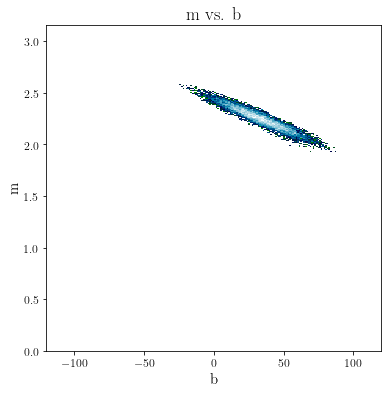

In [19]:
#now lets make 2d histogram of m vs b 
m_sample = p_sample[:,0]
b_sample = p_sample[:,1]

#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"b", fontsize = label_size)
ax.set_ylabel(r"m", fontsize = label_size)
ax.set_title(r'm vs. b', fontsize = title_size)

ax.hist2d(b_sample,m_sample,bins=100, norm = LogNorm(),cmap = 'ocean')

#set plot limits to look similar to Figure 4 (left panel)
plt.ylim(0,3.16)
plt.xlim(-120,120)

fig.savefig('/insert/path/here/ex6_m_vs_b_2dhist.png', bbox_inches = 'tight')

In [20]:
#to get the MAP line, we select the m and b values associated with the highest logL value
maxL = np.where(logL == max(logL))

#often times you will get multiple instances of the same value associated with the maxL value
#so I am using np.unique to ensure we only return one number
m_maxL = np.unique(m_sample[maxL])
b_maxL = np.unique(b_sample[maxL])

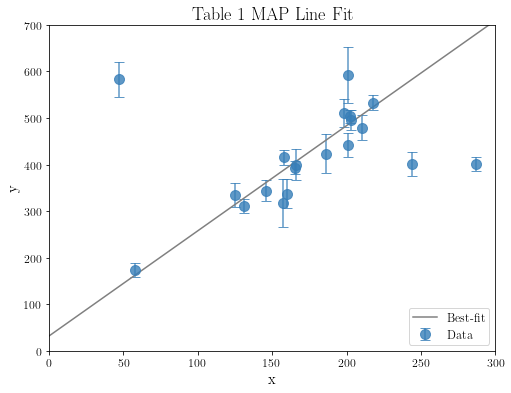

In [21]:
#now plot!
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 MAP Line Fit', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x, y, fmt = 'o', yerr=sigma_y, markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, m_maxL * x_line + b_maxL, color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')

#save the figure
fig.savefig('/insert/path/here/map_all_data.png', bbox_inches = 'tight')

It is a much better fit than in Ex. 2, the MAP line seems to fit the 'true' data trend well while acknowledging and accounting for the outliers.  

#### $\textbf{Exercise 7 (p. 17):}$ Solve  Exercise  6  but  now  plot  the  fully  marginalized (over $m,b,Y_b,V_b$) posterior distribution function for parameter $P_b$.  Is this distribution peaked about where you would expect, given the data?  Now repeat the problem, but dividing all the data uncertainty variances $\sigma_{yi}^2$ by 4 (or dividing the uncertainties $\sigma_{yi}$ by 2).  Again plot the fully marginalized posterior distribution function for parameter $P_b$. Your plots should look something like those in Figure 5.  

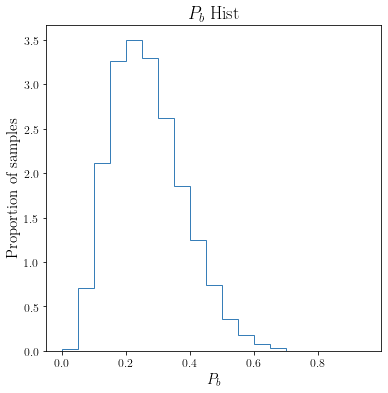

In [22]:
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"$P_b$", fontsize = label_size)
ax.set_ylabel(r"Proportion of samples", fontsize = label_size)
ax.set_title(r'$P_b$ Hist', fontsize = title_size)

#get the samples for Pb
Pb_sample = p_sample[:,4]
H = ax.hist(Pb_sample, bins = np.arange(0,1,0.05), density = True, color = blue, histtype = 'step')

Yes this distribution is peaked about where you would expect given the data, just from a glance you can tell that about 1/5 to 1/4 of the data is outliers so one would expect $P_b$ to peak around $\sim 0.2$.

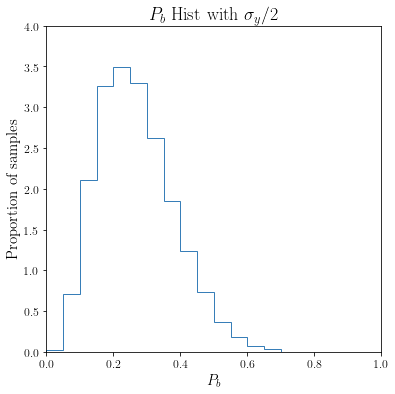

In [23]:
#make a histogram for Pb again, but this time dividing all the uncertainties by 2 and compare with fig. 5
#array of sigma_y divided by 2 defined previously (sigma_y2), reran previous cells replacing sigma_y with sigma_y2 in likelihood function

#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"$P_b$", fontsize = label_size)
ax.set_ylabel(r"Proportion of samples", fontsize = label_size)
ax.set_title(r'$P_b$ Hist with $\sigma_{y}/2$', fontsize = title_size)

#set axes to look the same as above
plt.xlim(0,1)
plt.ylim(0,4)

#get the samples for Pb
Pb_sample = p_sample[:,4]
H = ax.hist(Pb_sample, bins = np.arange(0,1,0.05), density = True, color = blue, histtype = 'step')

### 4. <u>Uncertainties in the best-fit parameters</u>

In this section, the authors start by discussing how the uncertainties in the best-fit parameters obtained by the LSQ method are given by the matrix shown in Eq. 18, as well as how they are given as a product of the modelling scheme from the above section, i.e. they can be determined from the probability distributions obtained by the MCMC outputs.  

For non-Bayesian situations, they also describe common empirical methods for calculating uncertainties in the best-fit parameters, known as bootstrap and jackknife.  Bootstrapping attempts to create new data sets which are similar to the original data set and evaluate the best-fit parameter through multiple trials of the fitting method.  While jackknife tests the sensitivity of the best-fit parameter evaluation to every data point (for more details on both methods, see Eq. 19-21 and the surrounding text in the paper).

#### $\textbf{Exercise 8 (p. 22):}$ Compute the standard uncertainty $\sigma_{m}^2$ obtained for the slope of the line  found  by  the  standard  fit  you  did  in  Exercise  2.   Now make jacknife (20 trials) and bootstrap estimates for the uncertainty $\sigma_{m}^2$.  How do the uncertainties compare and which seems most reasonable, given the data and uncertainties on the data?

In [24]:
from IPython.display import display, Markdown

#the variance from the fit in Ex. 2
display(Markdown(r'LSQ $\sigma_m^2$: {} ($\sigma_m$: {})'.format(np.round(m_var,3),np.round(np.sqrt(m_var),3))))

LSQ $\sigma_m^2$: 0.006 ($\sigma_m$: 0.077)

In [25]:
#now lets make a function where we compute the best-fit m with LSQ from Eq. 2, and then bootstrap to get the uncertainty of m
#number of draws should be the same as the length of the data
N = 20

#number of bootstrap trials should be comparable to the number of data points according to the paper,
#but the answer varies quite a bit when that is the case, so I set the number of trials to 1000, leading to less variation in the answer
M = 5000

#assign the x,y,sigma_y data to different variable names so we don't mess with the original data
x_data = x
y_data = y
sigma_y_data = sigma_y

#function for the method of choice
def LSQ(x, y, sigma_y):
    #copy and paste matrix multiplication from Ex. 2
    Y = np.reshape(y, (len(y),1))

    ones = np.ones_like(x)
    A = np.column_stack((ones, x))

    C = np.diag(sigma_y**2)

    A_T = A.T

    C_inv = np.linalg.inv(C)

    ATCINV = np.matmul(A_T, C_inv)

    ACA = np.matmul(ATCINV, A)

    ACA_inv = np.linalg.inv(ACA)

    ACY = np.matmul(ATCINV, Y)

    #column vector that has best fit parameters for b and m
    X = np.matmul(ACA_inv, ACY)
    
    #now lets return m since we are trying to sample the uncertainty in our calculation
    
    return X[1,0]

#define list to store the m estimates
m_estimates = []

#commence the bootstrap trials
for i in range(M):
    #since we have multiple arrays of data, lets sample the indices 
    index_samples = np.random.choice(N, size=N, replace=True)
    x_sample = x_data[index_samples]
    y_sample = y_data[index_samples]
    sigma_y_sample = sigma_y_data[index_samples]
    
    #estimate m with the LSQ function we defined above
    m_j = LSQ(x_sample, y_sample, sigma_y_sample)
    
    #add the estimate to the array defined above
    m_estimates = np.append(m_estimates, m_j)
    
#now lets calculate the uncertainty with Eq. 19

#the 'best-fit' m from Ex. 2 is
m = LSQ(x, y, sigma_y)

#so the uncertainty variance is
sig_m_sq = (1./M)*np.sum((m_estimates - m)**2)

In [26]:
display(Markdown(r'Bootstrapping $\sigma_m^2$: {} ($\sigma_m$: {})'.format(np.round(sig_m_sq,3),np.round(np.sqrt(sig_m_sq),3))))

Bootstrapping $\sigma_m^2$: 0.368 ($\sigma_m$: 0.607)

In [27]:
#now lets do jackknife as explained in the paper

#again, define list to store the m estimates
m_estimates_jk = []

#reassign the x,y,sigma_y data to different variable names 
x_data = x
y_data = y
sigma_y_data = sigma_y


#make the measurement N times, each time leaving out some point i for every point
for i in range(N):
    
    #now lets remove the chosen element from the arrays
    x_sample = np.delete(x_data, i)
    y_sample = np.delete(y_data, i)
    sigma_y_sample = np.delete(sigma_y_data, i) 
    
    #calculate the m estimate
    m_i = LSQ(x_sample, y_sample, sigma_y_sample)
    
    #add the estimate to the array defined above
    m_estimates_jk = np.append(m_estimates_jk, m_i)
    
#calculate the average m (Eq. 20)
m_avg_jk = (1/N)*np.sum(m_estimates_jk)

#then calculate the uncertainty (Eq. 21) note the factor in front only comes from the fact that we are 
#working in a Gaussian regime
sig_m_sq_jk = ((N-1)/N)*np.sum((m_estimates_jk - m_avg_jk)**2)

In [28]:
display(Markdown(r'Jackknife $\sigma_m^2$: {} ($\sigma_m$: {})'.format(np.round(sig_m_sq_jk,3),np.round(np.sqrt(sig_m_sq_jk),3))))

Jackknife $\sigma_m^2$: 0.764 ($\sigma_m$: 0.874)

The uncertainties from each method ($\sigma_{m, LSQ} = 0.077, \sigma_{m, BS} = 0.606, \sigma_{m, JK} = 0.874$) vary quite a bit.  The results from bootstrapping and jackknifing are closer to each other than that of the analytical calculation from LSQ, and reveal more uncertainty in $m$ due to the inclusion of noisy data.  While both methods have their advantages and reveal much about how the data influences the LSQ fit, I believe I prefer bootstrapping as it demonstrates a robust approach to sampling variation in $\sigma_m$ (which decreases as more trials are performed) and it allows more flexibility in the estimate.  

#### *skipping Exercise 9* 

### 5. <u> Non-Gaussian uncertainties & 6. Goodness of fit and unknown uncertainties </u>

In Section 5, as indicated by the title, the authors discuss how to handle non-Gaussian uncertainties.  They delve into multiple approaches to do so as well as how, in some cases, uncertainty can still be treated as Gaussian.  They maintain that the approach to be taken depends on the situation, the recommended one being the data rejection methods from Section 3, while the most justifiable one being to make an effort to truly understand and model the non-Gaussianity.   

In Section 6, the authors discuss how to evaluate the goodness of the model fitting the data.  They discuss how assessing a fit's 'goodness' depends on whether you trust the model or the data/it's uncertainties.  They explain how in the case that the generative model from Section 2 is a valid description of the data set, and given the linearity of the model (in the realm of large $N$ (# of data points)), the fit quantified by $/chi^2$ would be consdiered good if it's within the bounds calculated by Eq. 24.  This is followed by a discussion on how and why the value of $/chi^2$ can be outside of these boundaries, as well as how it is important that $/chi^2$ accounts for correlated uncertainties, as is often the case.    

#### $\textbf{Exercise 10 (p. 27):}$ Assess the $\chi^2$ value for the fit performed in Exercise 1.  Is the fit good?  What about for the fit performed in Exercise 2?

$\chi^2$ = $[Y - AX]^{T}C^{-1}[Y-AX]$

In [29]:
#Remember we want Chi^2 to be minimized for the fit to be good

#For Ex. 1 (inlier points) rerun cell that calculates the matrices for Ex. 1, then run this cell to calculate chi^2

#according to the text, if you were to assume that the model is a good description of the data, 
#in  the  limit  of  large N the rule of thumb is that—when the model is a good fit,  
#the uncertainties are Gaussian with known variances, and there are two linear parameters (m and b in this case)
#then chi^2 = [N-2] +- sqrt(2*(N-2)) (Eq. 24)

#number of data points
N = 16

#since Ex. 1 was only modelling the 'good' points, we would expect the calculated chi^2 to be close to this
chisqpred_upper = N - 2 + np.sqrt(2*(N-2))
chisqpred_lower = N - 2 - np.sqrt(2*(N-2))

#multiply A and X matrices
AX = np.matmul(A,X) 

Y_AX = Y - AX 

Y_AX_T = Y_AX.T

Y_AX_TC = np.matmul(Y_AX_T, C_inv)

chisq = np.matmul(Y_AX_TC,Y_AX)


In [30]:
display(Markdown(r'$\chi_{pred-lower}^2$ = ' + str(chisqpred_lower)))
display(Markdown(r'$\chi_{pred-upper}^2$ = ' + str(chisqpred_upper)))
display(Markdown(r'$\chi_{Ex. 1}^2$ = ' + str(chisq[0,0])))

$\chi_{pred-lower}^2$ = 8.708497377870819

$\chi_{pred-upper}^2$ = 19.29150262212918

$\chi_{Ex. 1}^2$ = 17.403171914904362

The $\chi^2$ value is within the limits calculated with Eq. 24, therefore it is a reasonable fit.

In [34]:
#For Ex. 2 (all data) rerun cell that calculates the matrices for Ex. 2, then calculate chi^2

N = 20

#since Ex. 1 was only modelling the 'good' points, we would expect the calculated chi^2 to be close to this
chisqpred_upper = N - 2 + np.sqrt(2*(N-2))
chisqpred_lower = N - 2 - np.sqrt(2*(N-2))

#multiply A and X matrices
AX = np.matmul(A,X) 

Y_AX = Y - AX 

Y_AX_T = Y_AX.T

Y_AX_TC = np.matmul(Y_AX_T, C_inv)

chisq = np.matmul(Y_AX_TC,Y_AX)


In [35]:
display(Markdown(r'$\chi_{pred-lower}^2$ = ' + str(chisqpred_lower)))
display(Markdown(r'$\chi_{pred-upper}^2$ = ' + str(chisqpred_upper)))
display(Markdown(r'$\chi_{Ex. 2}^2$ = ' + str(chisq[0,0])))

$\chi_{pred-lower}^2$ = 12.0

$\chi_{pred-upper}^2$ = 24.0

$\chi_{Ex. 2}^2$ = 289.96372278199937

The fit in Ex. 1 is much better than that of Ex. 2 since Ex. 1 was only doing the least squares fitting for the 'inlier' points, $\chi_{Ex. 2}^2$ is way outside of the bounds we calculated, making it not a good fit.

#### *skipping Exercise 11 and 12* 

### 7. <u> Arbitrary two-dimensional uncertainties </u>

#### $\textbf{Exercise 13 (p. 32):}$ Using the method of this Section,  fit the straight line y=mx+b to the x,y, $\sigma_{x}^2$, $\sigma_{xy}$, and $\sigma_{y}^2$ values of points 5 through 20 taken from Table 1 on page 6.  Make a plot showing the points, their two-dimensional uncertainties, and the best-fit line.  Your plot should look like Figure 9. 

In [36]:
#copy and paste data arrays here + make a new one for sigma_x 
x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])
sigma_x = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 5, 6, 6, 5, 9, 8, 6, 5])
p_xy = np.array([-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69, 0.3, -0.46, -0.03, 0.5, 0.73, -0.52, 0.9, 0.4, -0.78, -0.56])

In [37]:
#inititalize variables to run mcmc
#number of parameter space explorers
nwalkers = 100

#number of dimensions = number of parameters being explored
ndim = 2

#number of steps each walker takes
nsteps = 5000

#number of steps discarded
nburn = int(nsteps/2)

In [53]:
#function that describes the log probability of priors

#the text suggested performing the fit on theta and b_perp  
#where theta = arctan (m) -> the angle between the line and the x-axis
#and b perp = b cos(theta), but we'll just leave b as is in the probability functions (while still carrying out the b_perp calculation)
def lnprior(params):
#inputs: array of parameters being explored
    theta = params[0]
    b = params[1]
    
#We can guess that both theta and b_perp are flat (in prior space)
#but we know that theta should be somewhere between 0 and 180 degrees (i.e. 0 and pi)
    if  theta < 0. or theta > np.pi:
        return -np.inf
    else:
        return 0
        #if it is in the realm of possibility, return 0
        #it does not have to be 0, it just needs to be some constant
        

#function that describes the log likelihood of the given model parameters with the log probability of the priors   
def lnlikelihood(params,*args,**kwargs):
    theta = params[0] 
    b = params[1]
    
    #constant in likelihood function (Eq. 32)
    K = 0.
    
    #define unit vector v orthogonal to line that describes slope m
    v_T = np.array([-np.sin(theta), np.cos(theta)])
    
    v = np.reshape(v_T, (len(v_T), 1))
    
    #create array to store the orthogonal displacement of each data point from the line
    delta = []
    
    #create array to store orthogonal variance for each data point
    sig_sq = []
    
    #now loop through the arrays and construct the covariance matrix for each point (use the 5th element onwards of the Table 1 array data for Ex. 13 by changing the range
    #in the for loop)
    #for i in range(4, 19):       #for Ex. 13
    for i in range(len(x)):      #for Ex. 14
        #calculate covariance matrix for each dat
        cov = np.array([sigma_x[i]**2, p_xy[i]*sigma_x[i]*sigma_y[i], p_xy[i]*sigma_x[i]*sigma_y[i], sigma_y[i]**2])
        cov = np.reshape(cov, (2,2))
        
        #create data point column vector
        Zi = np.array([x[i], y[i]])
        Zi = np.reshape(Zi, (len(Zi), 1))
        
        #calculate the orthogonal displacement of the data point from the line and store it in the array created before
        disp = np.matmul(v_T,Zi) - b*np.cos(theta)
        
        #calculate the orthogonal variance for each data point then store in the array created before
        v_T_S = np.matmul(v_T, cov)
        var = np.matmul(v_T_S, v)
        
        delta = np.append(delta, disp)
        sig_sq = np.append(sig_sq, var)
        
    #okay now construct the likelihood function (Eq. 32)
    lnlhood = K - np.sum(delta**2/(2*sig_sq))
    
    #return negative infinity of 
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    #return sum of prior and likelihood
    return lp+lnlhood

In [54]:
#set some initial guesses for 'true' values of the parameters based on previous exercises

#knowing that theta = arctan(m) (put it in radians)
theta_true = 1.15
b_true = 34.0


#generates initial conditions based on drawing from a normal distribution centered around the 'true' values 
def gen_ICs():
    ret_array = np.zeros(ndim)
    ret_array[0] = np.random.normal(theta_true,1)
    ret_array[1] = np.random.normal(b_true,20.)
    return ret_array

#creates arrays of initial conditions for number of walkers specified
def gen_IC_array():
    return [gen_ICs() for i in range(nwalkers)]

ICs = gen_IC_array()

gen_ICs()

array([ 1.84675585, 41.16898385])

In [47]:
#look at emcee documentation 
filename = "/insert/path/here/ex13.h5"

#stores chain produced by mcmc in HDF5 file
backend = emcee.backends.HDFBackend(filename)

#clear the state of the chain and empty the backend
backend.reset(nwalkers, ndim)

In [48]:
#used to compute the log-probabilities for the ensemble in parallel.
#and also shows the progress of the process
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnlikelihood,pool=pool,backend=backend)
    sampler.run_mcmc(ICs,nsteps,progress=True);

100%|███████████████████████████████████████| 5000/5000 [01:24<00:00, 59.41it/s]


In [49]:
p_sample = sampler.get_chain(flat=True,discard=nburn)
logL = sampler.get_log_prob(flat=True,discard=nburn)


#p_sample= p_sample[logL>-100]
#logL = logL[logL>-100]

In [50]:
#choose the point with the highest likelihood for MAP line
theta_sample = p_sample[:,0]
b_sample = p_sample[:,1]

maxL_ind = np.where(logL == max(logL))

theta_maxL = theta_sample[maxL_ind]
b_maxL = b_sample[maxL_ind]

#calculate best fit m from theta_median
m = np.unique(np.tan(theta_maxL))
b_maxL = np.unique(b_maxL)

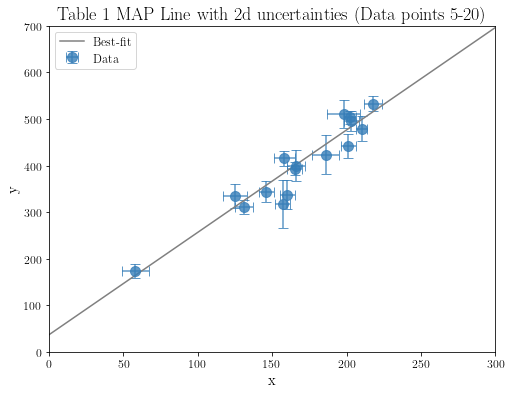

In [51]:
#now plot!
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 MAP Line with 2d uncertainties (Data points 5-20) ', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x[4:], y[4:], fmt = 'o', yerr=sigma_y[4:], xerr = sigma_x[4:], markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, m * x_line + b_maxL, color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')

#save the figure
fig.savefig('/insert/path/here/map_line_2d_uncertainties_points_5_20.png', bbox_inches = 'tight')

In [52]:
#compare results with Figure 9
display(Markdown(r'Best fit line: $y = {}x + {}$'.format(np.round(m[0],3), np.round(b_maxL[0],1))))

Best fit line: $y = 2.198x + 36.9$

#### $\textbf{Exercise 14 (p. 32):}$ Repeat Ex. 13 for all data, then follow up with trying to fit the outliers with the Bayesian mixture model procedure from Section 3

Rerun the 3rd and 4th cells in Ex. 13 but using all of the data points this time 

In [55]:
#inititalize variables to run mcmc
#number of parameter space explorers
nwalkers = 100

#number of dimensions = number of parameters being explored (2 for part 1, 5 for part 2)
ndim = 2

#number of steps each walker takes
nsteps = 5000

#number of steps discarded
nburn = int(nsteps/2)

In [56]:
#now set up the mcmc again
filename = "/insert/path/here/ex14a.h5"

#stores chain produced by mcmc in HDF5 file
backend = emcee.backends.HDFBackend(filename)

#clear the state of the chain and empty the backend
backend.reset(nwalkers, ndim)

In [57]:
#and run it
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnlikelihood,pool=pool,backend=backend)
    sampler.run_mcmc(ICs,nsteps,progress=True);

100%|███████████████████████████████████████| 5000/5000 [01:47<00:00, 46.70it/s]


In [58]:
#get the results
p_sample = sampler.get_chain(flat=True,discard=nburn)
logL = sampler.get_log_prob(flat=True,discard=nburn)


#p_sample= p_sample[logL>-100]
#logL = logL[logL>-100]

In [59]:
#choose the point with the highest likelihood for MAP line
theta_sample = p_sample[:,0]
b_sample = p_sample[:,1]

maxL_ind = np.where(logL == max(logL))

theta_maxL = theta_sample[maxL_ind]
b_maxL = b_sample[maxL_ind]

#calculate best fit m from theta_median
m = np.unique(np.tan(theta_maxL))
b_maxL = np.unique(b_maxL)

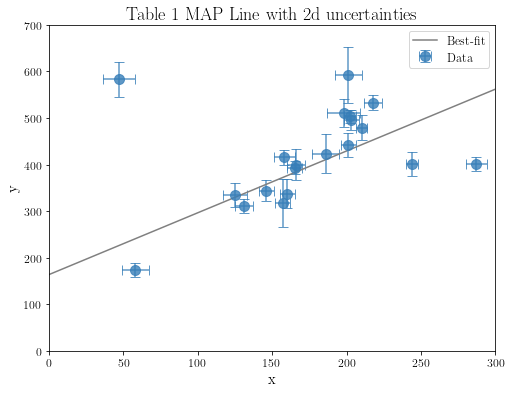

In [60]:
#now plot!
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Table 1 MAP Line with 2d uncertainties ', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x, y, fmt = 'o', yerr=sigma_y, xerr = sigma_x, markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, m * x_line + b_maxL, color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')

#save the figure
fig.savefig('/insert/path/here/map_line_2d_uncertainties_all_data.png', bbox_inches = 'tight')

In [61]:
#compare results with Figure 10 (left panel)
display(Markdown(r'Best fit line: $y = {}x + {}$'.format(np.round(m[0],2), np.round(b_maxL[0],0))))

Best fit line: $y = 1.33x + 164.0$

The fit is definitely much worse now that there are outliers.  Now lets try using the Bayesian mixture model from Section 3 (Ex. 6).  

In [62]:
#inititalize variables to run mcmc
#number of parameter space explorers
nwalkers = 100

#number of dimensions = number of parameters being explored
ndim = 5

#number of steps each walker takes
nsteps = 5000

#number of steps discarded
nburn = int(nsteps/2)

In [63]:
#function that describes the log probability of priors

#so the text suggested performing the fit on theta and b_perp
#where theta = arctan (m) -> the angle between the line and the x-axis
#and b perp = b cos(theta)
def lnprior(params):
#inputs: array of parameters being explored
    theta = params[0]
    b = params[1]
    Yb = params[2]
    Vb = params[3]
    Pb = params[4]

    
#We can guess that both theta and b_perp are flat
#but we know that theta should be somewhere between 0 and 180 degrees (i.e. 0 and pi)
    if theta < 0. or theta > np.pi or Pb < 0. or Pb > 1. or Vb < 0.:
        return -np.inf
    else:
        return 0
        #if it is in the realm of possibility, return 0
        #it does not have to be 0, it just needs to be some constant
        

#function that describes the log likelihood of the given model parameters with the log probability of the priors   
def lnlikelihood(params,*args,**kwargs):
    theta = params[0] 
    b = params[1]
    Yb = params[2]
    Vb = params[3]
    Pb = params[4]
    
    #constant in (foreground) likelihood function 
    K = 0.
    
    
    #define unit vector v orthogonal to line that describes slope m
    v_T = np.array([-np.sin(theta), np.cos(theta)])
    
    v = np.reshape(v_T, (len(v_T), 1))
    
    #create array to store the orthogonal displacement of each data point from the line
    delta = []
    
    #create array to store orthogonal variance for each data point
    sig_sq = []
    
    #now loop through the arrays and construct the covariance matrix for each point
    for i in range(len(x)):
        #calculate covariance matrix for each data point
        cov = np.array([sigma_x[i]**2, p_xy[i]*sigma_x[i]*sigma_y[i], p_xy[i]*sigma_x[i]*sigma_y[i], sigma_y[i]**2])
        cov = np.reshape(cov, (2,2))
        
        #create data point column vector
        Zi = np.array([x[i], y[i]])
        Zi = np.reshape(Zi, (len(Zi), 1))
        
        #calculate the orthogonal displacement of the data point from the line and store it in the array created before
        disp = np.matmul(v_T,Zi) - b*np.cos(theta)
        
        #calculate the orthogonal variance for each data point then store in the array created before
        v_T_S = np.matmul(v_T, cov)
        var = np.matmul(v_T_S, v)
        
        delta = np.append(delta, disp)
        sig_sq = np.append(sig_sq, var)
        
    #construct likelihood function following procedure with Bayesian Prob in section 3
    lhoodmodel = ((1-Pb)/np.sqrt(2*np.pi*sig_sq))*np.exp(-delta**2/(2*sig_sq))
    
    #only care about the y in the outlier points, y is the dependent variable!!
    outliers = Pb*(np.exp(-(y - Yb)**2./(2.*(Vb + sigma_y**2)))/np.sqrt(2.*np.pi*(Vb + sigma_y**2)))
    
    
    lnlhood = np.sum(np.log(lhoodmodel + outliers))
    
    #return negative infinity of 
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    #return sum of prior and likelihood
    return lp+lnlhood

In [64]:
#set some initial guesses for 'true' values of the parameters based on previous exercises

#knowing that theta = arctan(m) (put it in radians)
theta_true = 1.15
b_true = 34.0


In [65]:
from scipy.stats import loguniform 

#generates initial conditions based on drawing from a normal distribution centered around the 'true' values 
def gen_ICs():
    ret_array = np.zeros(ndim)
    ret_array[0] = np.random.normal(theta_true,1)
    ret_array[1] = np.random.normal(b_true,20.)
    ret_array[2] = np.random.uniform(300,600)  #assuming uninformative prior for Yb and Vb (as mentioned on page 12)
    ret_array[3] = loguniform.rvs(0.01, 4)  
    ret_array[4] = np.random.uniform(0,1)   #uniform distribution for Pb 

    
    return ret_array

#creates arrays of initial conditions for number of walkers specified
def gen_IC_array():
    return [gen_ICs() for i in range(nwalkers)]

ICs = gen_IC_array()

gen_ICs()

array([  2.50046567,   5.72449461, 431.43955314,   0.7438067 ,
         0.54423071])

In [66]:
#look at emcee documentation 
filename = "/insert/path/here/ex14b.h5"

#stores chain produced by mcmc in HDF5 file
backend = emcee.backends.HDFBackend(filename)

#clear the state of the chain and empty the backend
backend.reset(nwalkers, ndim)

In [67]:
#used to compute the log-probabilities for the ensemble in parallel.
#and also shows the progress of the process
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnlikelihood,pool=pool,backend=backend)
    sampler.run_mcmc(ICs,nsteps,progress=True);

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  lnlhood = np.sum(np.log(lhoodmodel + outliers))
/tmp/ipykernel_11304/3693070214.py:75: RuntimeWarning: invalid value encountered in log
  ln

In [68]:
p_sample = sampler.get_chain(flat=True,discard=nburn)
logL = sampler.get_log_prob(flat=True,discard=nburn)

p_sample= p_sample[logL>-100]
logL = logL[logL>-100]

In [69]:
#choose the point with the highest likelihood for MAP line
theta_sample = p_sample[:,0]
b_sample = p_sample[:,1]

maxL_ind = np.where(logL == max(logL))

theta_maxL = theta_sample[maxL_ind]
b_maxL = b_sample[maxL_ind]

#calculate best fit m from theta_median
m = np.unique(np.tan(theta_maxL))
b_maxL = np.unique(b_maxL)

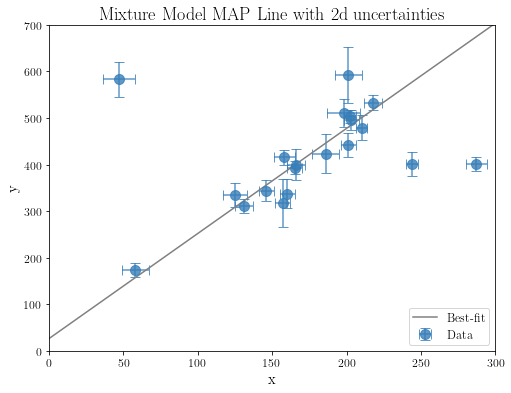

In [70]:
#now plot and compare with Figure 10 (right panel)
#set up the figure
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fig.set_facecolor('white')

#set fontsizes
plt.xticks(fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)
ax.set_xlabel(r"x", fontsize = label_size)
ax.set_ylabel(r"y", fontsize = label_size)
ax.set_title(r'Mixture Model MAP Line with 2d uncertainties ', fontsize = title_size)

#set x and y limits
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#create array of x values for the line to extend beyond the data
x_line = np.linspace(0, 300)

#plot the data points
ax.errorbar(x, y, fmt = 'o', yerr=sigma_y, xerr = sigma_x, markersize = ms, capsize = capsize, color = blue, alpha=alpha, label=r'Data') 

#plot the best-fit line
ax.plot(x_line, m * x_line + b_maxL, color = 'gray', label='Best-fit')

#make the legend
ax.legend(fontsize='large')

#save the figure
fig.savefig('/insert/path/here/mm_map_line_2d_uncertainties_all_data.png', bbox_inches = 'tight')

In [71]:
#compare results with Figure 10 (right panel)
display(Markdown(r'Best fit line: $y = {}x + {}$'.format(np.round(m[0],2), np.round(b_maxL[0],0))))

Best fit line: $y = 2.26x + 26.0$